##Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# specify the desired data location to the current working directory
%cd /content/drive/MyDrive/Dataset

/content/drive/.shortcut-targets-by-id/1hQJhZXCBbc369GWFH06FCrflHQ8EO2xS/Dataset


In [ ]:
# Keras prepocessing library
! pip install Keras-Preprocessing

##Import Library

In [ ]:
# Get the required Library
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import ResNet50V2, VGG16

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import numpy as np

import os
from tensorflow.keras import layers
from collections import defaultdict
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory

##Data Exploration

In [ ]:
os.listdir('/content/drive/MyDrive/Dataset/DatasetV2/Dataset/5Class_Split1000/Training')

['Abstract',
 'Realism',
 'Expressionism',
 'Romanticism',
 'Symbolism',
 'Primitivism',
 'Neoclassicism']

In [ ]:
os.listdir('/content/drive/MyDrive/Dataset/DatasetV2/Dataset/5Class_Split1000/Validation')

['Abstract',
 'Realism',
 'Expressionism',
 'Romanticism',
 'Symbolism',
 'Primitivism',
 'Neoclassicism']

In [ ]:
train_dir = '/content/drive/MyDrive/Dataset/DatasetV2/Dataset/5Class_Split1000/Training'
validation_dir = '/content/drive/MyDrive/Dataset/DatasetV2/Dataset/5Class_Split1000/Validation'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

train_dataset = image_dataset_from_directory(train_dir,
                                             label_mode = 'categorical',
                                             image_size = IMG_SIZE,
                                             batch_size = BATCH_SIZE,
                                             shuffle = True)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  label_mode ='categorical',
                                                  image_size = IMG_SIZE,
                                                  batch_size = BATCH_SIZE,
                                                  shuffle = True)


Found 5600 files belonging to 7 classes.
Found 1400 files belonging to 7 classes.


In [ ]:
# Fungsi untuk histogram equalization
def histogram_equalization(image):
    image = np.array(image)
    if len(image.shape) == 3 and image.shape[2] == 3:  # RGB image
        img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    elif len(image.shape) == 2:  # Grayscale image
        image = cv2.equalizeHist(image)
    return image

#def histogram_equalization_wrapper(image):
    image = tf.numpy_function(histogram_equalization, [image], tf.uint8)
    return image

Found 5600 files belonging to 7 classes.
['Abstract', 'Expressionism', 'Neoclassicism', 'Primitivism', 'Realism', 'Romanticism', 'Symbolism']


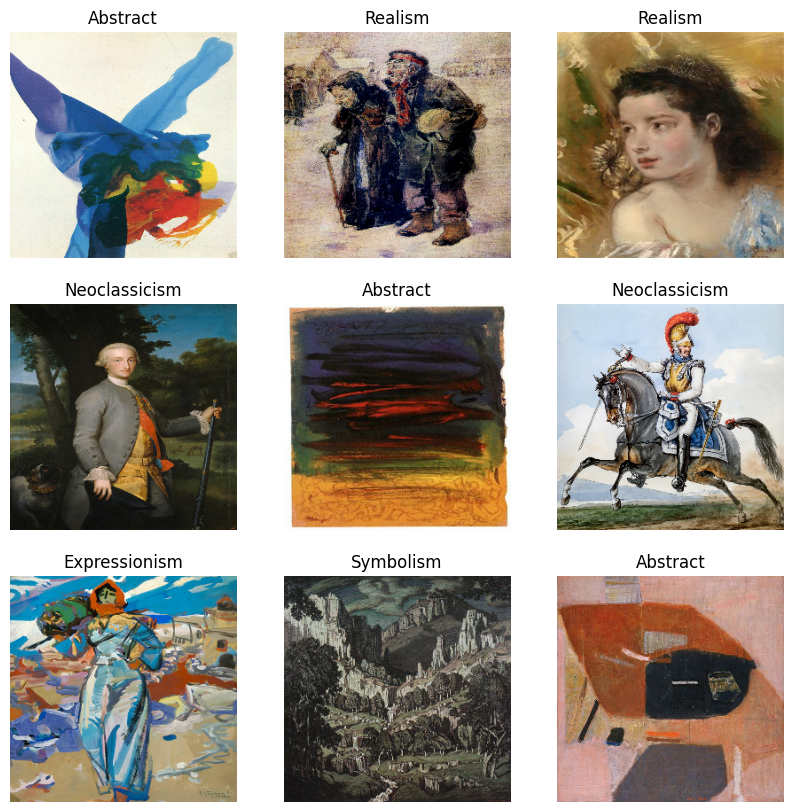

In [ ]:
data = image_dataset_from_directory(train_dir)

class_names = data.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

##Data Preprocessing

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

##Architecture

###Load MobileNetV2 Pretrained Model

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
feature, target = next(iter(train_dataset))
feature_batch = base_model(feature)
print(feature_batch.shape)

(32, 7, 7, 1280)


###Freeze Layer

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


###Create New Dense Layer

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)

x = layers.Dense(16384, activation='relu')(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(8192, activation='relu')(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(7, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = tf.keras.Model(inputs, x)

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_5 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_5 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                           

###Training Preperation

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

###Training

In [ ]:
initial_epochs = 100

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[es_callback])

Epoch 1/100
175/175 [==============================] - 231s 981ms/step - loss: 2.0127 - accuracy: 0.1616 - val_loss: 1.9690 - val_accuracy: 0.2857
Epoch 2/100
175/175 [==============================] - 169s 942ms/step - loss: 1.9393 - accuracy: 0.2304 - val_loss: 1.7554 - val_accuracy: 0.3257
Epoch 3/100
175/175 [==============================] - 173s 963ms/step - loss: 1.7614 - accuracy: 0.3013 - val_loss: 1.5679 - val_accuracy: 0.3686
Epoch 4/100
175/175 [==============================] - 174s 965ms/step - loss: 1.6259 - accuracy: 0.3698 - val_loss: 1.4405 - val_accuracy: 0.4657
Epoch 5/100
175/175 [==============================] - 173s 961ms/step - loss: 1.4970 - accuracy: 0.4327 - val_loss: 1.2964 - val_accuracy: 0.5543
Epoch 6/100
175/175 [==============================] - 174s 970ms/step - loss: 1.3789 - accuracy: 0.4971 - val_loss: 1.2184 - val_accuracy: 0.5779
Epoch 7/100
175/175 [==============================] - 172s 951ms/step - loss: 1.2790 - accuracy: 0.5473 - val_loss: 1

###Plot Loss And Accuracy

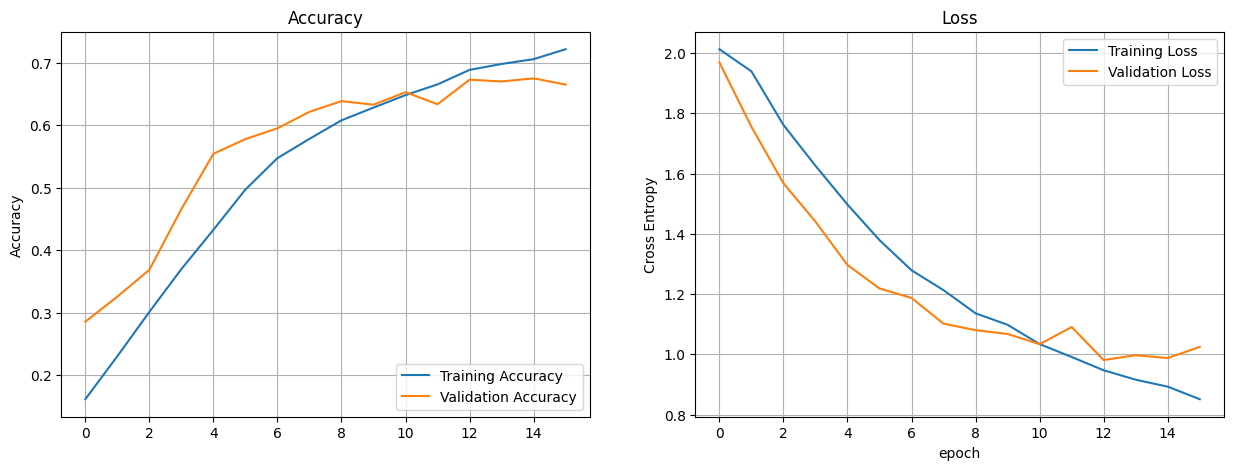

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.grid()
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

###Fine Tuning

In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_5 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_5 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                           

In [ ]:
fine_tune_epochs = 100
total_epochs =  21 + fine_tune_epochs
print(total_epochs)

121


In [ ]:
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[es_callback])

Epoch 16/121
175/175 [==============================] - 193s 983ms/step - loss: 0.8469 - accuracy: 0.7261 - val_loss: 0.9396 - val_accuracy: 0.7007
Epoch 17/121
175/175 [==============================] - 175s 970ms/step - loss: 0.7678 - accuracy: 0.7550 - val_loss: 0.8719 - val_accuracy: 0.7150
Epoch 18/121
175/175 [==============================] - 173s 954ms/step - loss: 0.7183 - accuracy: 0.7732 - val_loss: 0.9477 - val_accuracy: 0.6957
Epoch 19/121
175/175 [==============================] - 174s 966ms/step - loss: 0.6773 - accuracy: 0.7936 - val_loss: 0.8922 - val_accuracy: 0.7171
Epoch 20/121
175/175 [==============================] - 175s 975ms/step - loss: 0.6485 - accuracy: 0.7987 - val_loss: 0.9163 - val_accuracy: 0.7179
Epoch 21/121
175/175 [==============================] - 172s 952ms/step - loss: 0.6153 - accuracy: 0.8068 - val_loss: 0.8815 - val_accuracy: 0.7271
Epoch 22/121
175/175 [==============================] - 175s 965ms/step - loss: 0.5546 - accuracy: 0.8293 - val_

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

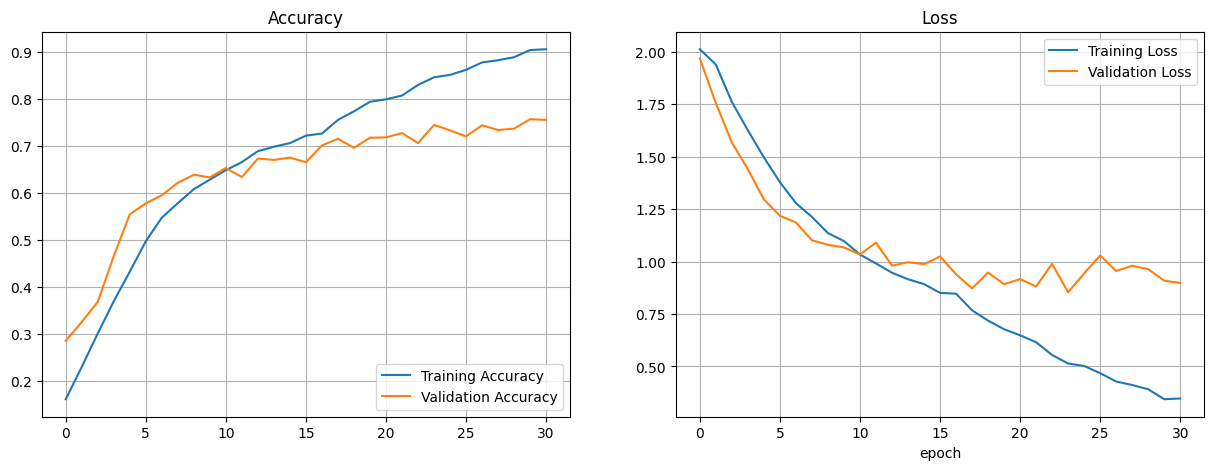

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Menggunakan callback EarlyStopping dan ReduceLROnPlateau
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

In [ ]:
# Melatih model dengan dataset yang sudah di-augmentasi
history_fine = model.fit(train_dataset,
                         epochs=121,  # Total epoch yang ingin dilanjutkan
                         initial_epoch=20,  # Memulai dari epoch ke-20
                         validation_data=validation_dataset,
                         callbacks=[es_callback, reduce_lr])

Epoch 21/121
175/175 [==============================] - 202s 1s/step - loss: 0.2742 - accuracy: 0.9339 - val_loss: 0.9373 - val_accuracy: 0.7536 - lr: 1.0000e-06
Epoch 22/121
175/175 [==============================] - 178s 992ms/step - loss: 0.2583 - accuracy: 0.9388 - val_loss: 0.9505 - val_accuracy: 0.7600 - lr: 1.0000e-06
Epoch 23/121
175/175 [==============================] - 178s 988ms/step - loss: 0.2373 - accuracy: 0.9452 - val_loss: 0.9743 - val_accuracy: 0.7614 - lr: 1.0000e-06
Epoch 24/121
175/175 [==============================] - 174s 960ms/step - loss: 0.2348 - accuracy: 0.9459 - val_loss: 0.9855 - val_accuracy: 0.7564 - lr: 1.0000e-06
Epoch 25/121
175/175 [==============================] - 179s 986ms/step - loss: 0.2358 - accuracy: 0.9413 - val_loss: 0.9778 - val_accuracy: 0.7621 - lr: 2.0000e-07
Epoch 26/121
175/175 [==============================] - 177s 987ms/step - loss: 0.2292 - accuracy: 0.9438 - val_loss: 0.9588 - val_accuracy: 0.7636 - lr: 2.0000e-07
Epoch 27/121


In [ ]:
# Save the model
model.save('model11_ArtNaon.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
tf.keras.models.save_model(model, '/content/drive/MyDrive/Dataset/Model')

In [ ]:
# You can also use this cell as a shortcut for downloading your model
from google.colab import files
files.download("model11_ArtNaon.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 36s 36s/step


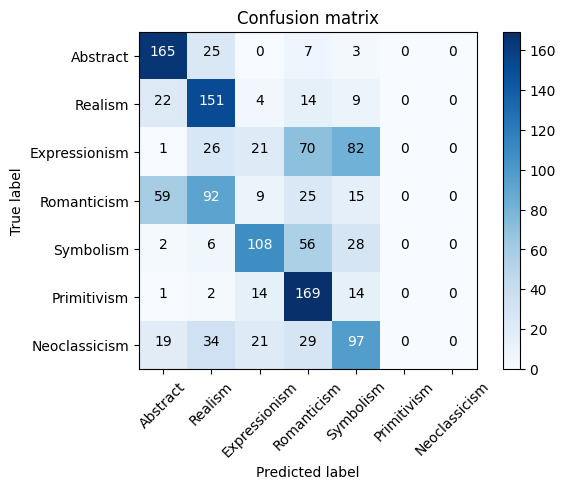

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import itertools

# Load your trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset/Model/model10_ArtNaon.h5')

# Menghitung jumlah sampel dalam dataset validasi
validation_samples = 0
for images, labels in validation_dataset:
    validation_samples += len(labels)

# Fungsi untuk mendapatkan prediksi dari model
def get_predictions_and_labels(dataset, model):
    predictions = []
    labels = []
    for images, batch_labels in dataset:
        batch_predictions = model.predict(images)
        predictions.extend(np.argmax(batch_predictions, axis=1))
        labels.extend(np.argmax(batch_labels, axis=1))
    return np.array(predictions), np.array(labels)

# Dapatkan prediksi dan label dari validation_dataset
Y_pred_classes, Y_true = get_predictions_and_labels(validation_dataset, model)

# Hitung confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Nama kelas (sesuaikan dengan kelas Anda)
class_names = ['Abstract', 'Realism', 'Expressionism', 'Romanticism', 'Symbolism', 'Primitivism', 'Neoclassicism']

# Fungsi untuk plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Fungsi ini mencetak dan menampilkan confusion matrix.
    Normalisasi bisa diterapkan dengan mengatur `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot confusion matrix dengan nama kelas
plot_confusion_matrix(confusion_mtx, classes=class_names)

# Menampilkan plot
plt.show()


1/1 [==============================] - 0s 44ms/step


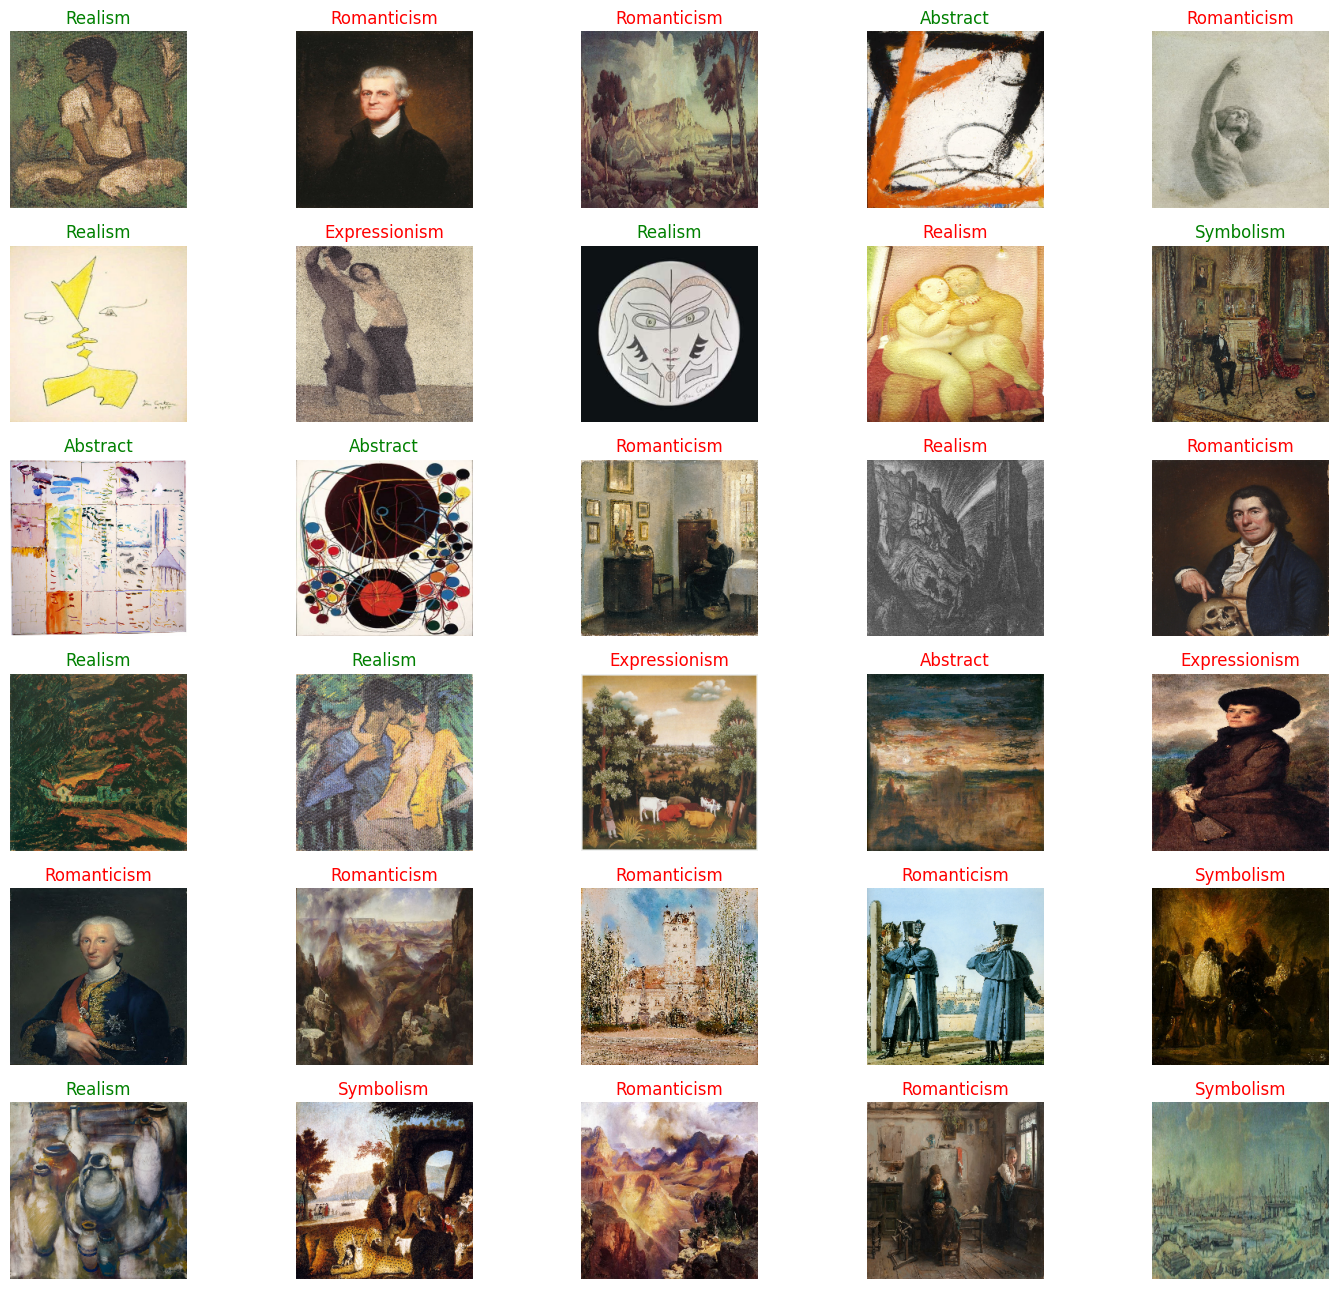

In [ ]:
# Mendapatkan satu batch dari validation dataset untuk plot gambar
img, labels = next(iter(validation_dataset))

# Define the class indices (mapping) as obtained previously
class_indices = {'Abstract': 0,'Realism':1, 'Expressionism':2, 'Romanticism':3, 'Symbolism':4, 'Primitivism': 5, 'Neoclassicism': 6}

# Reverse the class indices dictionary to map indices to class names for display
indices_class = {v: k for k, v in class_indices.items()}

# Predict the class of each image in the batch
predictions = model.predict(img)

# Set up the figure for plotting images
plt.figure(figsize=(15, 13))

# Plot each image in the batch
for i in range(30):  # Assuming you want to plot 30 images
    ax = plt.subplot(6, 5, i + 1)  # Adjust the number of rows and cols accordingly
    plt.imshow(img[i].numpy().astype("uint8"))

    # Get the predicted and true labels
    predicted_label = indices_class[np.argmax(predictions[i])]
    true_label = indices_class[np.argmax(labels[i])]

    # Set the title of each plot to the predicted label
    # If the prediction is correct, the title is set in green; otherwise, it's set in red
    title_color = 'green' if predicted_label == true_label else 'red'
    plt.title(predicted_label, color=title_color)
    plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
import os
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split

# Define the path to your dataset directory
dataset_dir = '/content/drive/MyDrive/Dataset/DatasetV2/WikiArt Art Movements Styles/Sampled_Arts_1000'

# The paths for the training and validation directories
train_dir = '/content/drive/MyDrive/Dataset/DatasetV2/Dataset/5Class_Split1000/Training'
val_dir = '/content/drive/MyDrive/Dataset/DatasetV2/Dataset/5Class_Split1000/Validation'

# Split ratio for validation
val_split_ratio = 0.2

# Create the training and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# List of categories to include (modify this list as needed)
categories_to_include = ['Primitivism', 'Neoclassicism']  # Replace with your actual category names

# Function to check if an image is valid
def is_valid_image(filepath):
    try:
        with Image.open(filepath) as img:
            img.verify()
        return True
    except (IOError, Image.DecompressionBombWarning):
        return False

# Function to copy files from source to destination
def copy_files(files, src_dir, dest_dir):
    for file_name in files:
        src_path = os.path.join(src_dir, file_name)
        dest_path = os.path.join(dest_dir, file_name)
        if is_valid_image(src_path):
            shutil.copy(src_path, dest_path)
        else:
            print(f"Invalid image file skipped: {src_path}")

# Process only the categories in the specified list
for category in categories_to_include:
    category_path = os.path.join(dataset_dir, category)

    # Check if the category directory exists
    if not os.path.exists(category_path):
        print(f"Category directory does not exist: {category_path}")
        continue

    # Create category-specific subdirectories in both the training and validation directories
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

    # List all files in the category directory
    all_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

    # Ensure the files are shuffled/randomized before splitting
    train_files, val_files = train_test_split(all_files, test_size=val_split_ratio, random_state=42)

    # Copy the training files to the training directory
    copy_files(train_files, category_path, os.path.join(train_dir, category))

    # Copy the validation files to the validation directory
    copy_files(val_files, category_path, os.path.join(val_dir, category))

print("Data split and copied successfully.")

Data split and copied successfully.


In [ ]:
import os

# Define paths
base_dir = '/content/drive/MyDrive/Dataset/DatasetV2/Dataset/5Class_Split1000'
train_dir = os.path.join(base_dir, 'Training')
val_dir = os.path.join(base_dir, 'Validation')

# Function to count the number of images in each folder
def count_images(directory):
    # Get the list of directories within the specified directory
    subdirectories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

    # Iterate over each directory and count the number of image files
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(directory, subdirectory)
        num_images = len([f for f in os.listdir(subdirectory_path) if os.path.isfile(os.path.join(subdirectory_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
        print(f"Number of images in {subdirectory}: {num_images}")

# Count images in the training directory
print("Training directory:")
count_images(train_dir)

# Count images in the validation directory
print("\nValidation directory:")
count_images(val_dir)

Training directory:
Number of images in Abstract: 800
Number of images in Realism: 800
Number of images in Expressionism: 800
Number of images in Romanticism: 800
Number of images in Symbolism: 800
Number of images in Primitivism: 800
Number of images in Neoclassicism: 800

Validation directory:
Number of images in Abstract: 200
Number of images in Realism: 200
Number of images in Expressionism: 200
Number of images in Romanticism: 200
Number of images in Symbolism: 200
Number of images in Primitivism: 200
Number of images in Neoclassicism: 200
